# Coaquisitions analyses by gene length

In [1]:
data_dir = '../data/'
taxonomic_id = '1236'
compiled_res_dir = '../data/compiled_results/'
plots_dir = '../plots/'

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np
import matplotlib as mpl

# use plotly for interactive plots
from plotly.offline import plot
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import math

import json
# read in the marker styles
with open('lib/plot_marker_styles.json', 'r') as f:
    marker_styles_dict = json.load(f)['marker_styles_dict']
    # this is a dictionary such that for each method it contains
    # a dict of marker styles for 'pyplot', 'plotly', 'marker_color', 'face_color'

# set global pyplot font to be serif
plt.rcParams['font.family'] = 'serif'

neighbor_genes_between_cutoffs = [1]
minimum_genome_size = 1000  # minimum genome size to consider a genome (i.e. contig or chromosome) for analysis
min_coacquisitions = 20  # minimum number of coacquisitions to consider a threshold of a method for analysis
# minimum number of coacquisitions with known positions, as a certain numerator, for considering it for percentage calculation
# e.g. for the percentage of coacquisitions that are neighbors,
# we need at least this meany neighbors that are coacquired for a given transfer threshold of a method to be considered
min_numerator = 0  # if 0, then in paper we add notes about the fact that there may be small number effects

In [3]:
import importlib


# reload the library in case it has been updated
if "clsl" in globals():
    importlib.reload(clsl)
from lib import coacq_logscale_summary_lib as clsl

In [4]:
# Scale the relevant rcParams by 1.5x, but use font_scale_factor for font sizes
scale_factor = 1.5
font_scale_factor = 2.5
for key in mpl.rcParams:
    try:
        if not "size" in key:
            continue
        # Use font_scale_factor if the key is related to font size
        if "font" in key:
            factor = font_scale_factor
        else:
            factor = scale_factor
        if isinstance(mpl.rcParams[key], (int, float)) and not isinstance(
            mpl.rcParams[key], bool
        ):
            mpl.rcParams[key] *= factor
        elif isinstance(mpl.rcParams[key], (list, tuple)):
            mpl.rcParams[key] = [
                (
                    v * factor
                    if isinstance(v, (int, float)) and not isinstance(v, bool)
                    else v
                )
                for v in mpl.rcParams[key]
            ]
    except Exception as e:
        print(f"Error scaling {key} from {mpl.rcParams[key]}: {e}")
        raise e

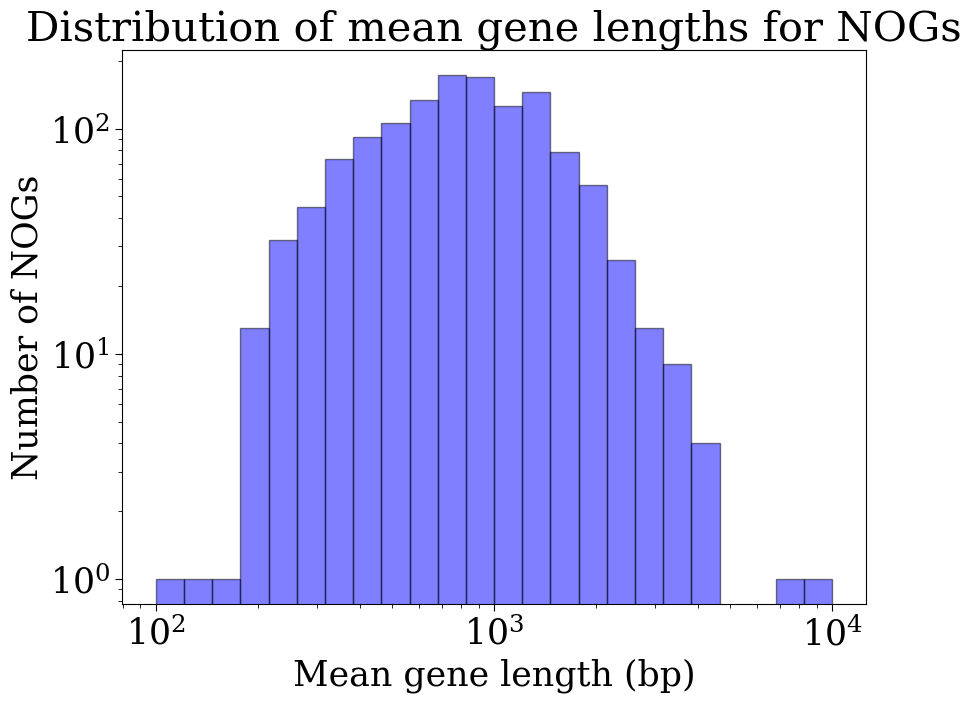

Short bin: 799.8647192285875, Long bin: 8586.088235294117
Median #genes in short bin: 74.0
Median #genes in long bin: 76.0
Number of NOGs in short genes bin: 650
Number of NOGs in long genes bin: 650


In [5]:
# read in the gene length file for this taxonomic id
gene_features_filepath = f'{data_dir}/{taxonomic_id}_gene_features.tsv'
gene_features_df = pd.read_csv(gene_features_filepath, sep='\t')
gene_features_df.loc[:, 'full_gene_id'] = gene_features_df['taxon_id'].astype(
    str) + '.' + gene_features_df['locus_tag'].astype(str)
gene_features_df = gene_features_df.set_index('full_gene_id')
gene_features_df['gene_length'] = gene_features_df['end'] - \
    gene_features_df['start']  # in bp

# read in the nog_members.tsv file for this taxonomic id. Column 3, 4 contain #taxa, #genes for the NOG
members_filepath = f'{data_dir}/{taxonomic_id}_nog_members.tsv'
members_df = pd.read_csv(members_filepath, sep='\t', header=None, usecols=[1, 2, 3, 5],
                         names=['NOG', '#taxa', '#genes', 'genes'])
# genes column is csv. Split and explode
members_df['genes'] = members_df['genes'].str.split(',')
members_exploded_df = members_df.explode('genes')
members_exploded_df = members_exploded_df.merge(
    gene_features_df, left_on='genes', right_index=True, how='left')
nog_gene_lengths_df = members_exploded_df.groupby('NOG').agg({'gene_length': 'mean', '#genes': 'median'}).rename(
    columns={'gene_length': 'mean_gene_length', 'nog_size': "median_nog_size"}).reset_index()

# plot hist distribution of mean gene lengths for NOGs. The distribution is log-normal so the bins are log-spaced
fig, ax = plt.subplots()
ax.hist(nog_gene_lengths_df['mean_gene_length'], bins=np.logspace(2, 4, 25).tolist(),
        color='blue', alpha=0.5, edgecolor='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Mean gene length (bp)')
ax.set_ylabel('Number of NOGs')
ax.set_title('Distribution of mean gene lengths for NOGs')
plt.show()

# split the bins into 3 categories: short, medium, long
# the bins are equally spaced (similar number of NOGs in each bin, not in logspace)
total_num_nogs = nog_gene_lengths_df.shape[0]
short_bin = float(np.percentile(nog_gene_lengths_df['mean_gene_length'], 50))
# medium_bin = float(np.percentile(nog_gene_lengths_df['mean_gene_length'], 66))
long_bin = float(np.percentile(nog_gene_lengths_df['mean_gene_length'], 100))
# print(f'Short bin: {short_bin}, Medium bin: {medium_bin}, Long bin: {long_bin}')
print(f'Short bin: {short_bin}, Long bin: {long_bin}')

# print median #genes in each bin
print(f'Median #genes in short bin: {nog_gene_lengths_df[nog_gene_lengths_df["mean_gene_length"] <= short_bin]["#genes"].median()}')
# print(f'Median #genes in medium bin: {nog_gene_lengths_df[(nog_gene_lengths_df["mean_gene_length"] > short_bin) & (nog_gene_lengths_df["mean_gene_length"] <= medium_bin)]["#genes"].median()}')
print(f'Median #genes in long bin: {nog_gene_lengths_df[nog_gene_lengths_df["mean_gene_length"] > short_bin]["#genes"].median()}')

short_nogs = nog_gene_lengths_df[nog_gene_lengths_df['mean_gene_length'].between(
    0, short_bin)]
# medium_nogs = nog_gene_lengths_df[nog_gene_lengths_df['mean_gene_length'].between(
#     short_bin, medium_bin)]
long_nogs = nog_gene_lengths_df[nog_gene_lengths_df['mean_gene_length'].between(
    short_bin, long_bin)]

print(f'Number of NOGs in short genes bin: {short_nogs.shape[0]}')
# print(f'Number of NOGs in medium genes bin: {medium_nogs.shape[0]}')
print(f'Number of NOGs in long genes bin: {long_nogs.shape[0]}')

In [6]:
# now we perform the neighboring co-acquisitions analysis but for the binned branch lengths
# read in the data: chromosome locations, and coacquisitions for each method
coacquisitions_dfs = clsl.load_data(compiled_res_dir)
# for each method, find the minimum number of transfers under different transfer thresholds
coacquisitions_dfs = clsl.calculate_min_transfers(coacquisitions_dfs)

# the following methods have manually set thresholds (gain-loss penalty ratios or MAD values)
methods_for_manual_thresholds = [
    "count_mp",
    "gloome_mp",
    "gloome_mp.without_tree",
    "wn",
]
manual_threshold_coacquisitions_dfs_dict = {}
for meth in methods_for_manual_thresholds:
    # read in the data
    manual_threshold_coacquisitions_dfs_dict[meth] = clsl.load_data(
        os.path.join(compiled_res_dir, meth.split(".")[0]),
        include_manual_thresholds=True,
    )
    # calculate the minimum number of transfers
    manual_threshold_coacquisitions_dfs_dict[meth] = clsl.calculate_min_transfers(
        manual_threshold_coacquisitions_dfs_dict[meth]
    )


The following methods are included in the coacquisitions data:
['gloome.ml', 'gloome.ml.without_tree', 'angst', 'ale', 'ranger-fast', 'ranger', 'count.ml', 'wn']
The following methods are included in the coacquisitions data:
['count.mp.0.33', 'count.mp.0.5', 'count.mp.1', 'count.mp.2', 'count.mp.3', 'count.mp.4', 'count.mp.5', 'count.mp.6', 'count.mp.7', 'count.mp.8']
The following methods are included in the coacquisitions data:
['gloome.mp.0.33', 'gloome.mp.0.5', 'gloome.mp.1', 'gloome.mp.2', 'gloome.mp.3', 'gloome.mp.4', 'gloome.mp.5', 'gloome.mp.6', 'gloome.mp.7', 'gloome.mp.8', 'gloome.mp.without_tree.0.33', 'gloome.mp.without_tree.0.5', 'gloome.mp.without_tree.1', 'gloome.mp.without_tree.2', 'gloome.mp.without_tree.3', 'gloome.mp.without_tree.4', 'gloome.mp.without_tree.5', 'gloome.mp.without_tree.6', 'gloome.mp.without_tree.7', 'gloome.mp.without_tree.8']
The following methods are included in the coacquisitions data:
['gloome.mp.0.33', 'gloome.mp.0.5', 'gloome.mp.1', 'gloome.mp.

In [7]:
def summarize_coacquisitions_for_bins(coacquisitions_dfs, neighbor_genes_between_cutoffs, minimum_genome_size, 
                                      bins: list, bin_names: list, min_coacquisitions:int):
    binned_coacq_summary_dfs = {}
    for bin_name, bin_df in zip(bin_names, bins):
        print(f'Processing {bin_name} bin')
        # keep only the bin nogs in the coacquisitions_dfs
        this_bin_coacquisitions_dfs = {method: coacquisitions_dfs[method][coacquisitions_dfs[method]['nog1'].isin(
            bin_df['NOG']) & coacquisitions_dfs[method]['nog2'].isin(bin_df['NOG'])] for method in coacquisitions_dfs.keys()}
        # summarize the coacquisitions for each method across transfer thresholds
        this_bin_coacq_summary_df = clsl.summarize_coacquisitions_parallel(
            this_bin_coacquisitions_dfs,
            neighbor_genes_between_cutoffs,
            minimum_genome_size,
            min_coacquisitions=min_coacquisitions,
        )
        # replace zeros with NaNs in certain columns
        this_bin_coacq_summary_df = clsl.replace_zeros_with_nan(this_bin_coacq_summary_df)

        for manual_meth in methods_for_manual_thresholds:
            manual_meth_bin_coacquisitions_dfs = manual_threshold_coacquisitions_dfs_dict[manual_meth]
            # keep only the bin nogs in the coacquisitions_dfs
            manual_meth_bin_coacquisitions_dfs = {method: manual_meth_bin_coacquisitions_dfs[method][manual_meth_bin_coacquisitions_dfs[method]['nog1'].isin(
                bin_df['NOG']) & manual_meth_bin_coacquisitions_dfs[method]['nog2'].isin(bin_df['NOG'])] for method in manual_meth_bin_coacquisitions_dfs.keys()}
            manual_meth_bin_coacq_summary_df = clsl.summarize_coacquisitions_manual_thresholds(
                manual_meth_bin_coacquisitions_dfs,
                neighbor_genes_between_cutoffs,
                minimum_genome_size,
                method=manual_meth.replace("_", ".", 1),
                min_coacquisitions=min_coacquisitions,
            )
            # replace zeros with NaNs in certain columns
            manual_meth_bin_coacq_summary_df = clsl.replace_zeros_with_nan(manual_meth_bin_coacq_summary_df)
            this_bin_coacq_summary_df = pd.concat([this_bin_coacq_summary_df, manual_meth_bin_coacq_summary_df], ignore_index=True)
            
            this_bin_coacq_summary_df = pd.concat(
                [this_bin_coacq_summary_df, manual_meth_bin_coacq_summary_df], ignore_index=True
            )
        
        # sort this_bin_coacq_summary_df by method and transfer threshold
        this_bin_coacq_summary_df = this_bin_coacq_summary_df.sort_values(
            by='method', ascending=True
        ).reset_index(drop=True)

        # add this df to the binned_coacq_summary_dfs dict
        binned_coacq_summary_dfs[bin_name] = this_bin_coacq_summary_df
    return binned_coacq_summary_dfs

In [8]:
# summarize the coacquisitions for each method across transfer thresholds
# for short, medium, long gene length bins
binned_coacq__by_gene_length_summary_dfs = summarize_coacquisitions_for_bins(coacquisitions_dfs, neighbor_genes_between_cutoffs, minimum_genome_size,
                                                            [short_nogs, 
                                                            #  medium_nogs, 
                                                             long_nogs], 
                                                            ['short gene length', 
                                                            #  'medium gene length', 
                                                             'long gene length'], min_coacquisitions)

# display head of each of these dataframes
for bin_name, bin_df in binned_coacq__by_gene_length_summary_dfs.items():
    print(f'{bin_name} bin')
    display(bin_df.head())


Processing short gene length bin
Methods in the dataframe: ['gloome.ml' 'gloome.ml.without_tree' 'angst' 'ale' 'ranger-fast' 'ranger'
 'count.ml' 'wn']
Method count.mp has less than 20 coacquisitions with known gene positions. Skipping.
Methods in the dataframe: ['count.mp']
Method gloome.mp has less than 20 coacquisitions with known gene positions. Skipping.
Skipping non-numeric threshold value: without_tree.8
Skipping non-numeric threshold value: without_tree.7
Skipping non-numeric threshold value: without_tree.6
Skipping non-numeric threshold value: without_tree.5
Skipping non-numeric threshold value: without_tree.4
Skipping non-numeric threshold value: without_tree.3
Skipping non-numeric threshold value: without_tree.2
Skipping non-numeric threshold value: without_tree.1
Skipping non-numeric threshold value: without_tree.0.5
Skipping non-numeric threshold value: without_tree.0.33
Methods in the dataframe: ['gloome.mp']
Skipping non-numeric threshold value: gloome.mp.8
Skipping non-

,method,coacquisitions with known positions,neighbors (1 intervening genes),neighbor (max 1 intervening genes) percentage,cotransfer and neighbor (max 1 intervening genes),cotransfer and neighbor (max 1 intervening genes) percentage,expected percentage of neighboring coacquisitions (max 1 intervening genes),observed minus expected percentage of neighboring coacquisitions (max 1 intervening genes),cotransfers,cotransfer percentage,transfer threshold
0,ale,32903,100.0,0.303924,36.0,0.109413,0.119335,0.184589,3745.0,11.381941,0.24
1,ale,5000,17.0,0.340000,7.0,0.140000,0.120851,0.219149,621.0,12.420000,0.49
2,ale,10000,38.0,0.380000,17.0,0.170000,0.121007,0.258993,1352.0,13.520000,0.35
3,ale,20000,56.0,0.280000,26.0,0.130000,0.120479,0.159521,2572.0,12.860000,0.27
4,ale,50000,152.0,0.304000,54.0,0.108000,0.119223,0.184777,4834.0,9.668000,0.20


long gene length bin


,method,coacquisitions with known positions,neighbors (1 intervening genes),neighbor (max 1 intervening genes) percentage,cotransfer and neighbor (max 1 intervening genes),cotransfer and neighbor (max 1 intervening genes) percentage,expected percentage of neighboring coacquisitions (max 1 intervening genes),observed minus expected percentage of neighboring coacquisitions (max 1 intervening genes),cotransfers,cotransfer percentage,transfer threshold
0,ale,50000,220.0,0.440000,93.0,0.186000,0.122017,0.317983,3631.0,7.262000,0.17
1,ale,20000,93.0,0.465000,45.0,0.225000,0.122557,0.342443,1962.0,9.810000,0.24
2,ale,25685,123.0,0.478879,59.0,0.229706,0.123345,0.355533,2331.0,9.075336,0.22
3,ale,51350,227.0,0.442064,95.0,0.185005,0.121870,0.320194,3730.0,7.263875,0.17
4,ale,77015,344.0,0.446666,139.0,0.180484,0.122435,0.324231,5373.0,6.976563,0.13


Note that y axis variable is the observed minus expected percentage of neighboring coacquisitions,
       for a maximum of 1 intervening gene between coacquired genes
       and x axis variable is the number of coacquisitions with known positions
Legend: ALE: + (blue), Ranger: square (green, filled for 'fast' version else empty),
         ANGST: diamond, GLOOME: triangle-up (yellow, MP is filled, ML is empty), 
         GLOOME (without input species tree): triangle-down (red, MP is filled, ML is empty),
         COUNT: circle (purple, MP is filled, ML is empty), Wn: x (black)


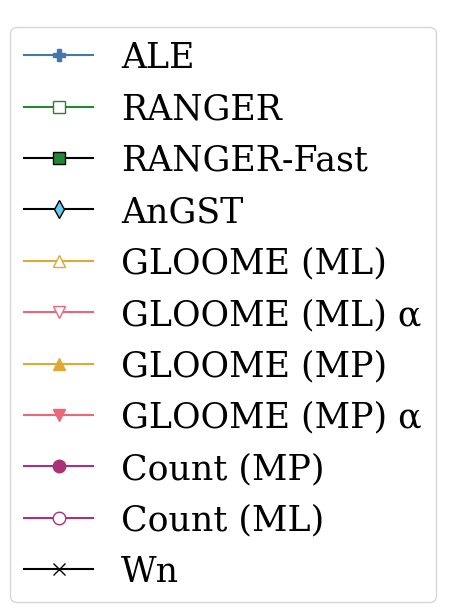

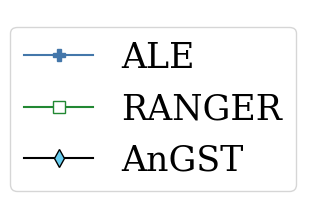

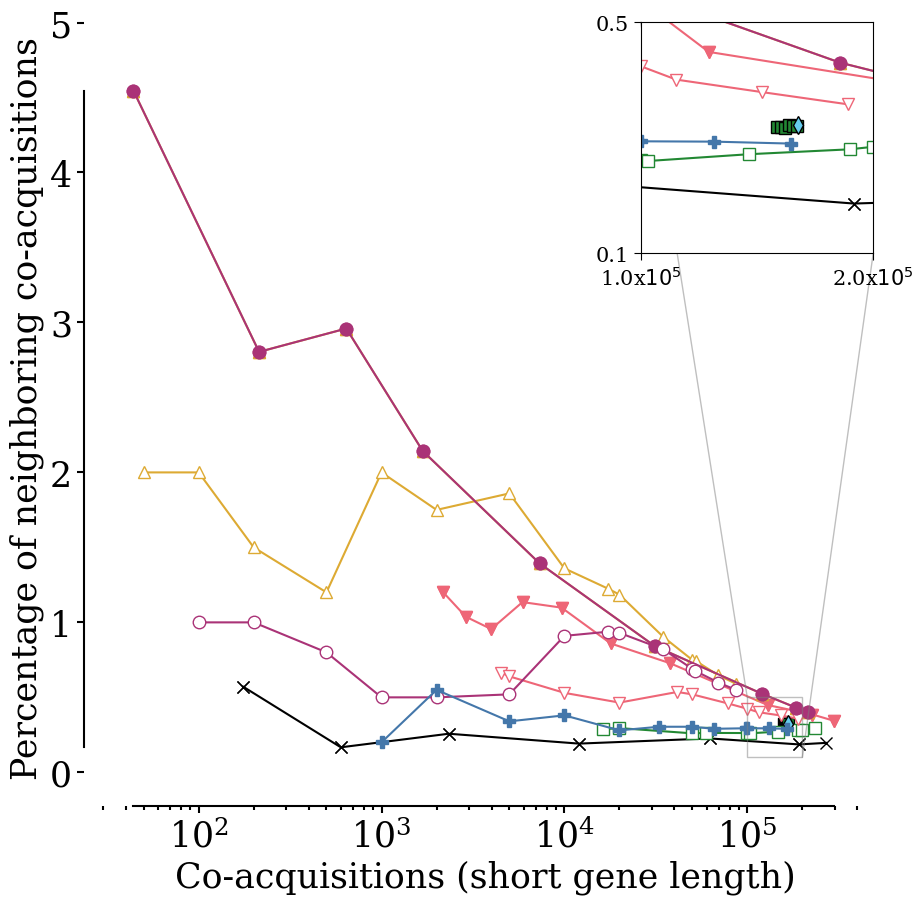

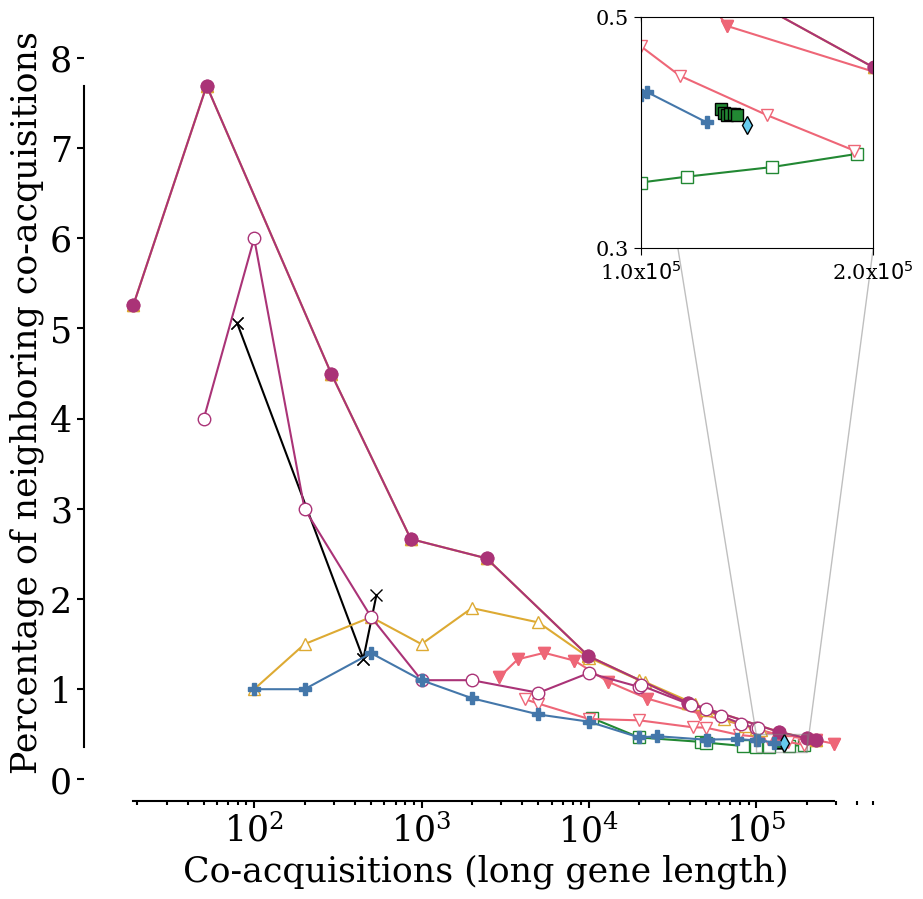

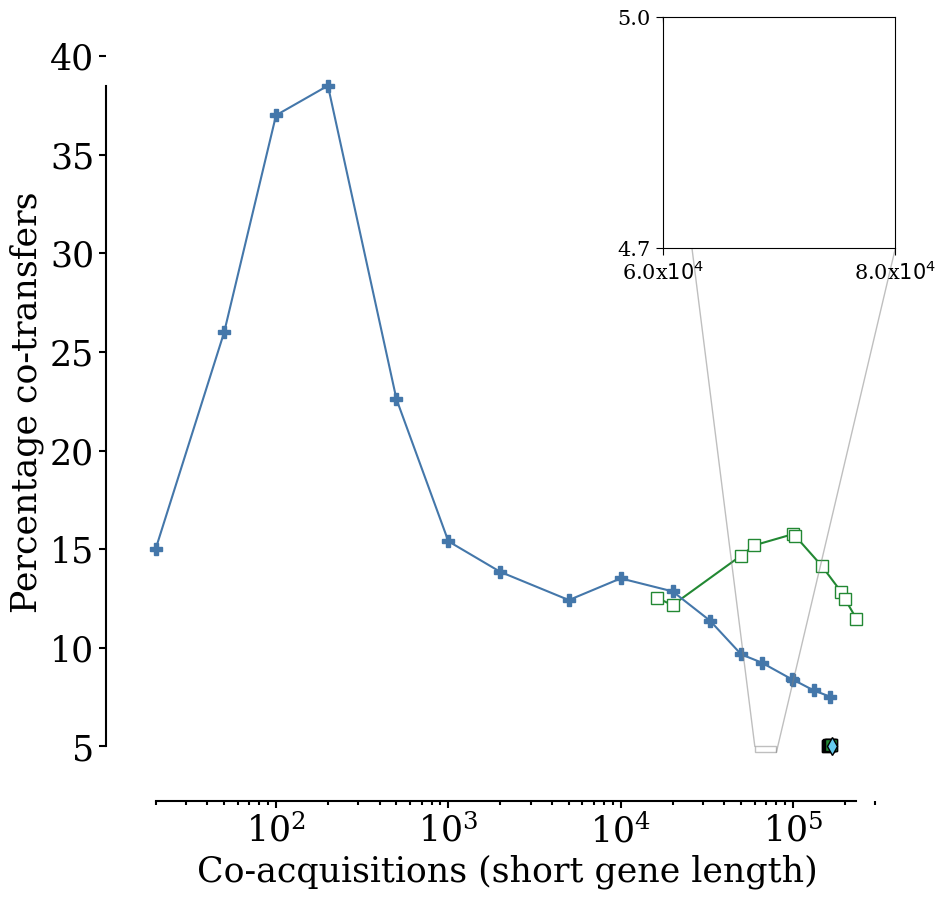

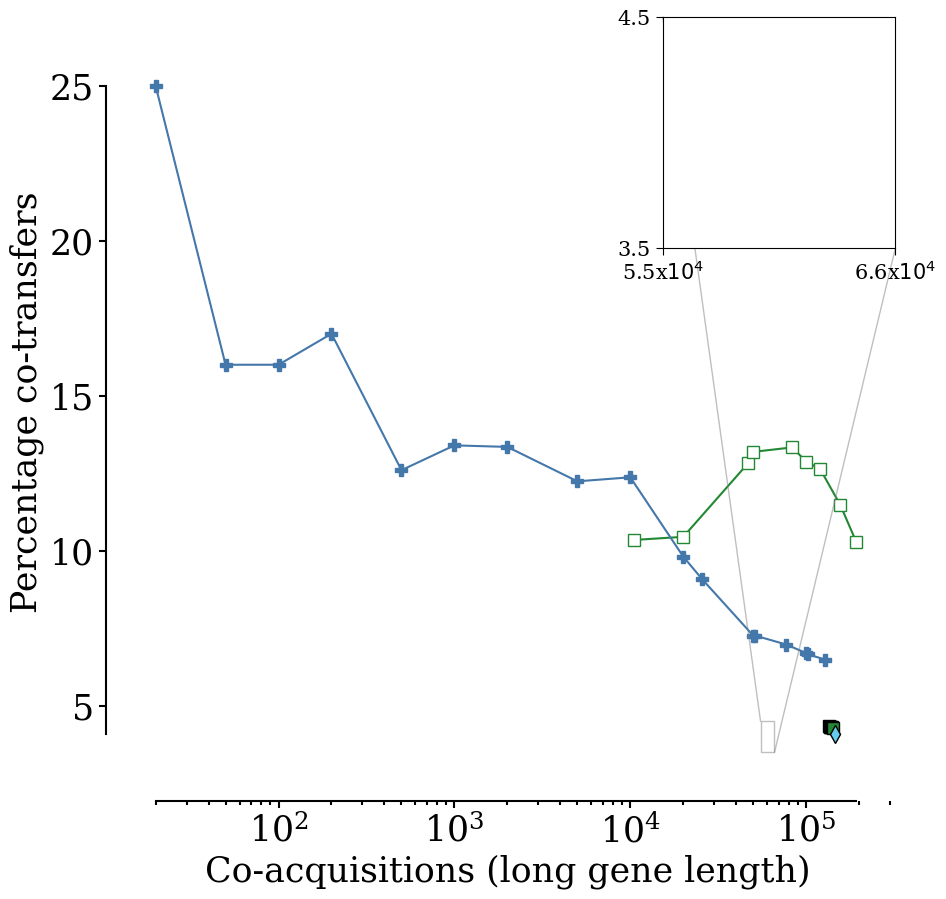

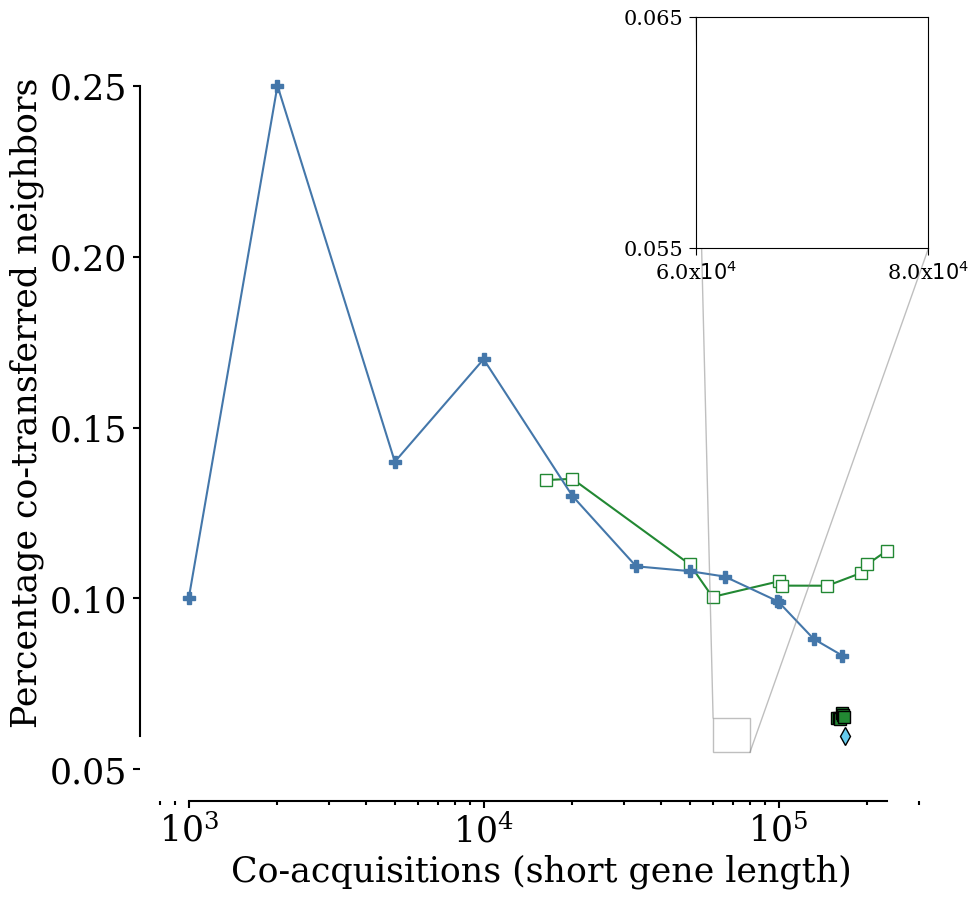

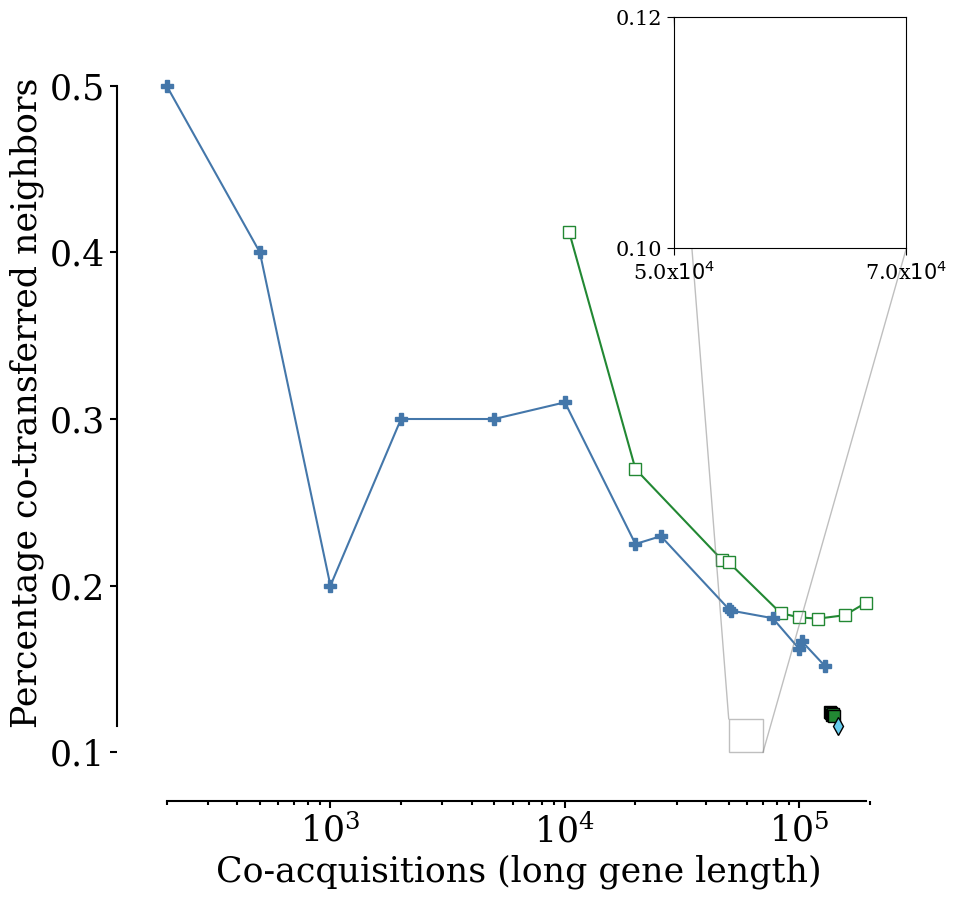

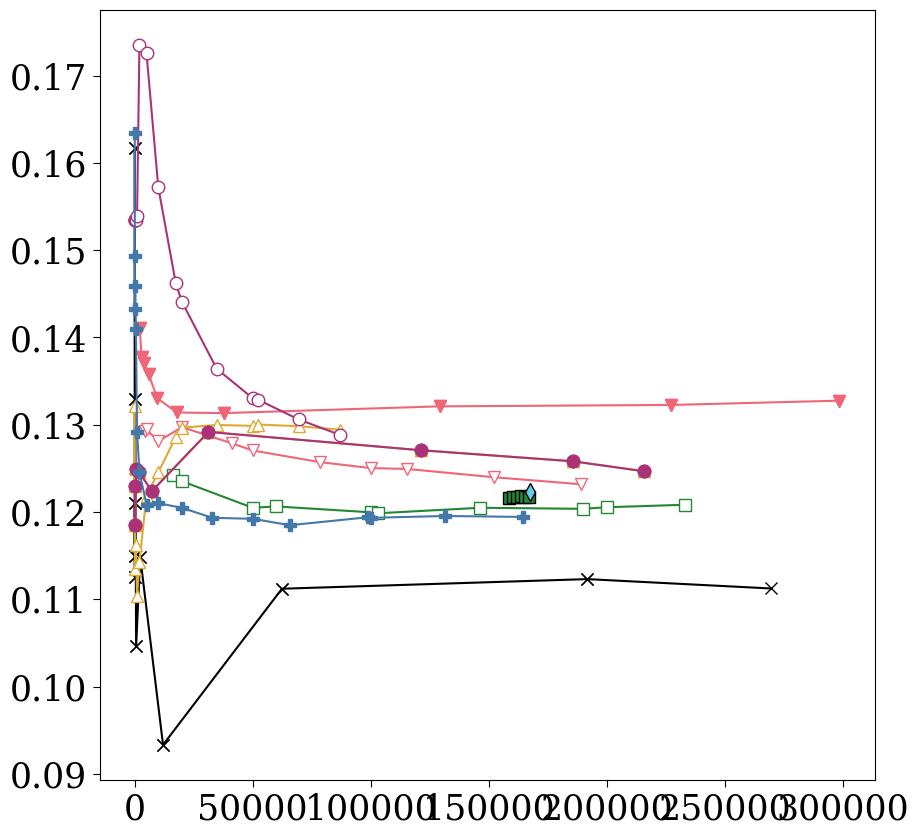

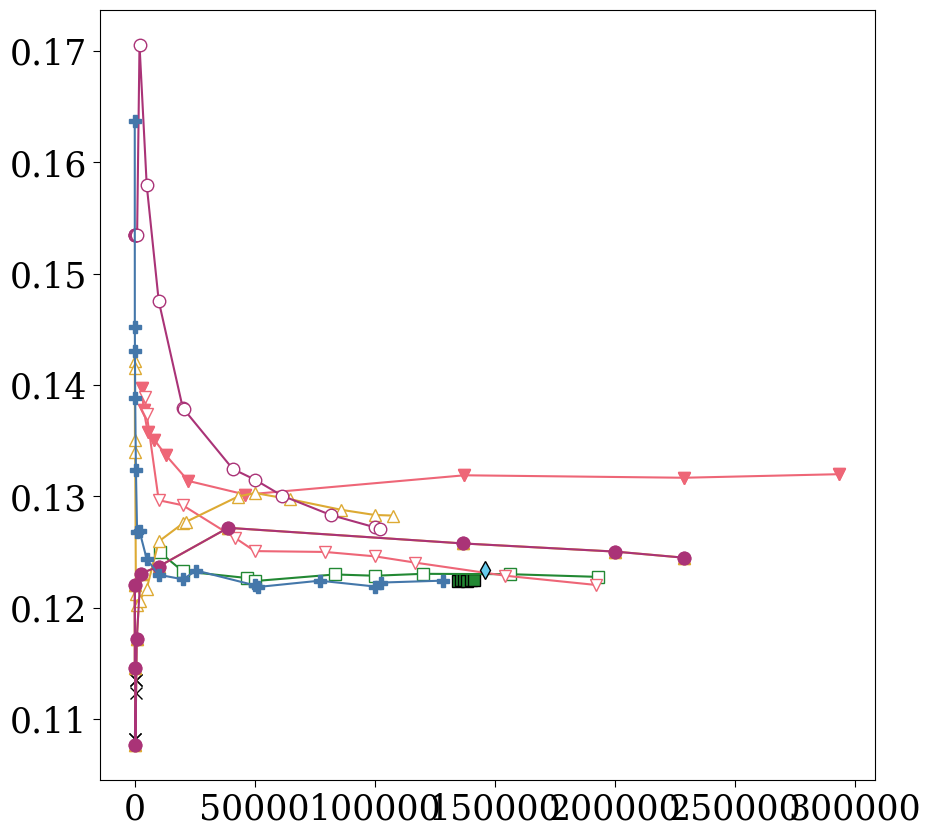

In [9]:

print("Note that y axis variable is the observed minus expected percentage of neighboring coacquisitions,\n \
      for a maximum of 1 intervening gene between coacquired genes\n \
      and x axis variable is the number of coacquisitions with known positions")

# print legend
print("Legend: ALE: + (blue), Ranger: square (green, filled for 'fast' version else empty),\n \
        ANGST: diamond, GLOOME: triangle-up (yellow, MP is filled, ML is empty), \n \
        GLOOME (without input species tree): triangle-down (red, MP is filled, ML is empty),\n \
        COUNT: circle (purple, MP is filled, ML is empty), Wn: x (black)")

# plot just the legend without any plot
fig, ax = plt.subplots(figsize=(1, 5))
for sm_key in marker_styles_dict.keys():
    if type(marker_styles_dict[sm_key]) is dict:
        method = sm_key
        ax.plot([], [], marker=marker_styles_dict[method]['marker_pyplot'],
            color=marker_styles_dict[method]['marker_color'],
            markerfacecolor=marker_styles_dict[method]['face_color'], label=marker_styles_dict[method]['label'])
ax.legend()
ax.axis('off')
plt.savefig(f'{plots_dir}/legend_tall.jpg', bbox_inches='tight', dpi=300)
plt.show()

# also plot the legend without any plot but for only the explicit phylogenetic methods
explicit_phylogenetic_methods = ['ale', 'ranger', 'range-fast', 'angst']
fig, ax = plt.subplots(figsize=(3, 1))
for sm_key in marker_styles_dict.keys():
    if type(marker_styles_dict[sm_key]) is dict:
        method = sm_key
        if method in explicit_phylogenetic_methods:
            ax.plot([], [], marker=marker_styles_dict[method]['marker_pyplot'],
                color=marker_styles_dict[method]['marker_color'],
                markerfacecolor=marker_styles_dict[method]['face_color'], label=marker_styles_dict[method]['label'])
ax.legend()
ax.axis('off')
plt.savefig(f'{plots_dir}/legend_wide_explicit_phylogenetic_methods.jpg', bbox_inches='tight', dpi=300)
plt.show()

# Plot excess over random expectation percentage of neighboring coacquisitions
fig, ax = plt.subplots(figsize=(10, 10))
inset_positions = [0.7, 0.7, 0.3, 0.3]
insets = [inset_positions]
x_inset_lims = [[1e5, 2e5]]
y_inset_lims = [[0.1, 0.5]]
fig, ax = clsl.plot_multiple_figs_with_insets(fig, [ax], {'short gene length': binned_coacq__by_gene_length_summary_dfs['short gene length']},
                            'coacquisitions with known positions', "neighbor (max 1 intervening genes) percentage",
                            marker_styles_dict, x_inset_lims, y_inset_lims,
                            'Co-acquisitions', 'Percentage of neighboring co-acquisitions', insets)
# save fig
plt.savefig(f'{plots_dir}/neighboring_coacq_short_gene_length.jpg', bbox_inches='tight', dpi=300)
plt.show()


# fig, ax = plt.subplots(figsize=(10, 10))
# y_inset_lims = [[0.2, 0.5]]
# fig, ax = clsl.plot_multiple_figs_with_insets(fig, [ax], {'medium gene length': binned_coacq__by_gene_length_summary_dfs['medium gene length']},
#                             'coacquisitions with known positions', "neighbor (max 1 intervening genes) percentage",
#                             marker_styles_dict, x_inset_lims, y_inset_lims,
#                             'Co-acquisitions', 'Percentage of neighboring co-acquisitions', insets)
# plt.savefig(f'{plots_dir}/neighboring_coacq_medium_gene_length.jpg', bbox_inches='tight', dpi=300)
# plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
y_inset_lims = [[0.3, 0.5]]
fig, ax = clsl.plot_multiple_figs_with_insets(fig, [ax], {'long gene length': binned_coacq__by_gene_length_summary_dfs['long gene length']},
                            'coacquisitions with known positions', "neighbor (max 1 intervening genes) percentage",
                            marker_styles_dict, x_inset_lims, y_inset_lims,
                            'Co-acquisitions', 'Percentage of neighboring co-acquisitions', insets)
plt.savefig(f'{plots_dir}/neighboring_coacq_long_gene_length.jpg', bbox_inches='tight', dpi=300)
plt.show()

# Plot percentage of co-transfers
fig, ax = plt.subplots(figsize=(10, 10))
insets = [[0.7, 0.7, 0.3, 0.3]]
x_inset_lims = [[6e4, 8e4]]
y_inset_lims = [[4.7, 5.0]]
fig, ax = clsl.plot_multiple_figs_with_insets(fig, [ax], {'short gene length': binned_coacq__by_gene_length_summary_dfs['short gene length']},
                                 'coacquisitions with known positions', 'cotransfer percentage',
                                    marker_styles_dict, x_inset_lims, y_inset_lims,
                                    'Co-acquisitions', 'Percentage co-transfers', insets)
plt.savefig(f'{plots_dir}/cotransfers_short_gene_length.jpg', bbox_inches='tight', dpi=300)
plt.show()

# fig, ax = plt.subplots(figsize=(10, 10))
# x_inset_lims = [[6e4, 7e4]]
# y_inset_lims = [[5, 5.5]]
# fig, ax = clsl.plot_multiple_figs_with_insets(fig, [ax], {'medium gene length': binned_coacq__by_gene_length_summary_dfs['medium gene length']},
#                                     'coacquisitions with known positions', 'cotransfer percentage',
#                                     marker_styles_dict, x_inset_lims, y_inset_lims,
#                                     'Co-acquisitions', 'Percentage co-transfers', insets)
# plt.savefig(f'{plots_dir}/cotransfers_medium_gene_length.jpg', bbox_inches='tight', dpi=300)
# plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
x_inset_lims = [[5.5e4, 6.6e4]]
y_inset_lims = [[3.5, 4.5]]
fig, ax = clsl.plot_multiple_figs_with_insets(fig, [ax], {'long gene length': binned_coacq__by_gene_length_summary_dfs['long gene length']},
                                    'coacquisitions with known positions', 'cotransfer percentage',
                                    marker_styles_dict, x_inset_lims, y_inset_lims,
                                    'Co-acquisitions', 'Percentage co-transfers', insets)
plt.savefig(f'{plots_dir}/cotransfers_long_gene_length.jpg', bbox_inches='tight', dpi=300)
plt.show()

# Plot percentage of co-transferred neighbors
fig, ax = plt.subplots(figsize=(10, 10))
insets = [[0.7, 0.7, 0.3, 0.3]]
x_inset_lims = [[6e4, 8e4]]
y_inset_lims = [[0.055, 0.065]]
fig, ax = clsl.plot_multiple_figs_with_insets(fig, [ax], {'short gene length': binned_coacq__by_gene_length_summary_dfs['short gene length']},
                               'coacquisitions with known positions', 'cotransfer and neighbor (max 1 intervening genes) percentage',
                               marker_styles_dict, x_inset_lims, y_inset_lims,
                               'Co-acquisitions', 'Percentage co-transferred neighbors', insets)
plt.savefig(f'{plots_dir}/cotransferred_neighbors_short_gene_length.jpg', bbox_inches='tight', dpi=300)
plt.show()

# fig, ax = plt.subplots(figsize=(10, 10))
# x_inset_lims = [[6e4, 7e4]]
# y_inset_lims = [[0.08, 0.11]]
# fig, ax = clsl.plot_multiple_figs_with_insets(fig, [ax], {'medium gene length': binned_coacq__by_gene_length_summary_dfs['medium gene length']},
#                                'coacquisitions with known positions', 'cotransfer and neighbor (max 1 intervening genes) percentage',
#                                marker_styles_dict, x_inset_lims, y_inset_lims,
#                                'Co-acquisitions', 'Percentage co-transferred neighbors', insets)
# plt.savefig(f'{plots_dir}/cotransferred_neighbors_medium_gene_length.jpg', bbox_inches='tight', dpi=300)
# plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
x_inset_lims = [[5e4, 7e4]]
y_inset_lims = [[0.10, 0.12]]
fig, ax = clsl.plot_multiple_figs_with_insets(fig, [ax], {'long gene length': binned_coacq__by_gene_length_summary_dfs['long gene length']},
                               'coacquisitions with known positions', 'cotransfer and neighbor (max 1 intervening genes) percentage',
                               marker_styles_dict, x_inset_lims, y_inset_lims,
                               'Co-acquisitions', 'Percentage co-transferred neighbors', insets)
plt.savefig(f'{plots_dir}/cotransferred_neighbors_long_gene_length.jpg', bbox_inches='tight', dpi=300)
plt.show()

# Plot expected percentage of neighboring coacquisitions
fig, ax = plt.subplots(figsize=(10, 10))
insets = [None]
x_inset_lims = [[1.3e4, 1.6e4]]
y_inset_lims = [[0.0, 0.5]]
fig, ax = clsl.plot_multiple_figs_with_insets(fig, [ax], {'short gene length': binned_coacq__by_gene_length_summary_dfs['short gene length']},
                               'coacquisitions with known positions', 'expected percentage of neighboring coacquisitions (max 1 intervening genes)',
                               marker_styles_dict, x_inset_lims, y_inset_lims,
                               'Co-acquisitions', 'Expected percentage of\n neighboring co-acquisitions', insets)
plt.savefig(f'{plots_dir}/expected_neighboring_coacq_short_gene_length.jpg', bbox_inches='tight', dpi=300)
plt.show()

# fig, ax = plt.subplots(figsize=(10, 10))
# y_inset_lims = [[0.2, 0.5]]
# fig, ax = clsl.plot_multiple_figs_with_insets(fig, [ax], {'medium gene length': binned_coacq__by_gene_length_summary_dfs['medium gene length']},
#                                'coacquisitions with known positions', 'expected percentage of neighboring coacquisitions (max 1 intervening genes)',
#                                marker_styles_dict, x_inset_lims, y_inset_lims,
#                                'Co-acquisitions', 'Expected percentage of\n neighboring co-acquisitions', insets)
# plt.savefig(f'{plots_dir}/expected_neighboring_coacq_medium_gene_length.jpg', bbox_inches='tight', dpi=300)
# plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
y_inset_lims = [[0.2, 0.5]]
fig, ax = clsl.plot_multiple_figs_with_insets(fig, [ax], {'long gene length': binned_coacq__by_gene_length_summary_dfs['long gene length']},
                               'coacquisitions with known positions', 'expected percentage of neighboring coacquisitions (max 1 intervening genes)',
                               marker_styles_dict, x_inset_lims, y_inset_lims,
                               'Co-acquisitions', 'Expected percentage of\n neighboring co-acquisitions', insets)
plt.savefig(f'{plots_dir}/expected_neighboring_coacq_long_gene_length.jpg', bbox_inches='tight', dpi=300)
plt.show()


In [16]:
import numpy as np

# for each bin_df, find the mean of the corrected percentage of neighboring coacquisitions

agg_var = "neighbor (max 1 intervening genes) percentage"
ranked_method_mean_performance_dfs_dict = {}
for bin_name, bin_df in binned_coacq__by_gene_length_summary_dfs.items():
    print(f"Processing {bin_name} bin")
    # first remove from bin_df any of the rows where the number of coacquisitions is < 1e3 and > 1e5
    bin_df = bin_df[
        (bin_df["coacquisitions with known positions"] >= 1e3)
        & (bin_df["coacquisitions with known positions"] <= 1e5)
    ]
    # for each method, find the mean of the corrected percentage of neighboring coacquisitions
    #     ...for each method. Groupby method,
    #     and find max of the transfer threshold
    #     value of mean of observed minus expected percentage of neighboring coacquisitions (max 1 intervening genes)
    #     and std of the values across the transfer thresholds
    percentage_binned_df = (
        bin_df.groupby("method")
        .agg(
            {
                agg_var: [
                    "mean",
                    # "std",
                    # lambda x: x.idxmax(),
                    # lambda x: x.max(),
                ]
            }
        )
        .reset_index()
    )
    percentage_binned_df.columns = [
        "Method",
        "Mean",
        # "Std",
        # "Max IDX",
        # "Max",
    ]
    # percentage_binned_df["Stringency"] = bin_df.loc[
    #     percentage_binned_df["Max IDX"]
    # ]["transfer threshold"].values
    # percentage_binned_df = percentage_binned_df.drop(
    #     columns=["Max IDX"]
    # )
    # sort descending by Mean
    percentage_binned_df = percentage_binned_df.sort_values(
        by="Mean", ascending=False
    )
    # replace NaN with 'NA'
    percentage_binned_df = percentage_binned_df.fillna("NA")
    # show the dataframe
    display(percentage_binned_df)

    # print latex without index
    print(percentage_binned_df.to_latex(index=False, float_format="%.3f"))

    # replace method names with the 'label' from marker_styles_dict[method]['label']
    percentage_binned_df['Method'] = percentage_binned_df['Method'].apply(
        lambda x: marker_styles_dict[x]['label'] if x in marker_styles_dict else x)

    # add the df to the ranked_method_mean_performance_dfs_dict
    ranked_method_mean_performance_dfs_dict[bin_name] = percentage_binned_df

# combine dfs in the ranked_method_mean_performance_dfs_dict into a single df
## with a header row for each bin type
# Prepare multi-row header

# Get the number of methods per bin (should be the same for both bins)
n_methods = [len(df) for df in ranked_method_mean_performance_dfs_dict.values()]

# Build the multi-row columns
columns = []
for bin_name, df in ranked_method_mean_performance_dfs_dict.items():
    columns.extend([(bin_name, "Method"), (bin_name, "Mean")])

# Build the data for the table
data = []
for i in range(max(n_methods)):
    row = []
    for bin_name, df in ranked_method_mean_performance_dfs_dict.items():
        if i < len(df):
            row.extend([df.iloc[i, 0], df.iloc[i, 1]])
        else:
            row.extend([np.nan, np.nan])
    data.append(row)

multi_index = pd.MultiIndex.from_tuples(columns)
ranked_method_mean_performance_table = pd.DataFrame(data, columns=multi_index)

# Display the table
display(ranked_method_mean_performance_table)
# display latex
print(ranked_method_mean_performance_table.to_latex(index=False, float_format="%.3f").replace('NaN', ''))

Processing short gene length bin


,Method,Mean
2,count.mp,1.459038
5,gloome.mp,1.459038
3,gloome.ml,1.182876
6,gloome.mp.without_tree,1.002476
1,count.ml,0.693826
4,gloome.ml.without_tree,0.529880
0,ale,0.323616
7,ranger,0.273504
8,wn,0.225007


\begin{tabular}{lr}
\toprule
Method & Mean \\
\midrule
count.mp & 1.459 \\
gloome.mp & 1.459 \\
gloome.ml & 1.183 \\
gloome.mp.without_tree & 1.002 \\
count.ml & 0.694 \\
gloome.ml.without_tree & 0.530 \\
ale & 0.324 \\
ranger & 0.274 \\
wn & 0.225 \\
\bottomrule
\end{tabular}

Processing long gene length bin


,Method,Mean
2,count.mp,1.556436
5,gloome.mp,1.556436
6,gloome.mp.without_tree,1.127643
3,gloome.ml,1.100029
1,count.ml,0.899985
4,gloome.ml.without_tree,0.646442
0,ale,0.606561
7,ranger,0.449427


\begin{tabular}{lr}
\toprule
Method & Mean \\
\midrule
count.mp & 1.556 \\
gloome.mp & 1.556 \\
gloome.mp.without_tree & 1.128 \\
gloome.ml & 1.100 \\
count.ml & 0.900 \\
gloome.ml.without_tree & 0.646 \\
ale & 0.607 \\
ranger & 0.449 \\
\bottomrule
\end{tabular}



short gene length           long gene length          
             Method      Mean           Method      Mean
0        Count (MP)  1.459038       Count (MP)  1.556436
1       GLOOME (MP)  1.459038      GLOOME (MP)  1.556436
2       GLOOME (ML)  1.182876    GLOOME (MP) α  1.127643
3     GLOOME (MP) α  1.002476      GLOOME (ML)  1.100029
4        Count (ML)  0.693826       Count (ML)  0.899985
5     GLOOME (ML) α  0.529880    GLOOME (ML) α  0.646442
6               ALE  0.323616              ALE  0.606561
7            RANGER  0.273504           RANGER  0.449427
8                Wn  0.225007              NaN       NaN

\begin{tabular}{lrlr}
\toprule
\multicolumn{2}{r}{short gene length} & \multicolumn{2}{r}{long gene length} \\
Method & Mean & Method & Mean \\
\midrule
Count (MP) & 1.459 & Count (MP) & 1.556 \\
GLOOME (MP) & 1.459 & GLOOME (MP) & 1.556 \\
GLOOME (ML) & 1.183 & GLOOME (MP) α & 1.128 \\
GLOOME (MP) α & 1.002 & GLOOME (ML) & 1.100 \\
Count (ML) & 0.694 & Count (ML) & 0.900 \\
GLOOME (ML) α & 0.530 & GLOOME (ML) α & 0.646 \\
ALE & 0.324 & ALE & 0.607 \\
RANGER & 0.274 & RANGER & 0.449 \\
Wn & 0.225 &  &  \\
\bottomrule
\end{tabular}

